In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *
from scipy.stats import genextreme
from scipy.special import gamma, gammainc

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## GEV

In [445]:
x = np.linspace(-4, 4, 100)

In [135]:
loc = 0
scale = 1
shape = -0.5

In [136]:
rv = genextreme(shape, loc=loc, scale=scale)

In [340]:
def gev_cdf(x, mu, sigma, xi):
    x = np.atleast_1d(x)
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = np.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g[x<support] = 0
    if xi < 0:
        g[x>support] = 1
    return g

In [341]:
a = 5

In [342]:
np.array(a)

array(5)

In [362]:
shape=0.1
loc=-2

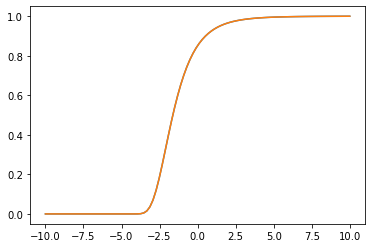

In [363]:
rv = genextreme(-shape, loc=loc, scale=scale)
truth = rv.cdf(x)
mine = gev_cdf(x, loc, scale, shape)
plt.plot(x, truth)
plt.plot(x, mine)

In [357]:
gev_cdf(0, loc, scale, shape)

array([0.36787944])

In [561]:
def crps_gev(y, mu, sigma, xi):
#     pdb.set_trace()
    py = gev_cdf2(y, mu, sigma, xi)
    p0 = gev_cdf2(np.array([0.]), mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - gammainc(1-xi, -np.log(py))
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * gammainc(1-xi, -2 * np.log(p0))
    )
    return crps

In [491]:
def crps_gev2(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)

    crps = (mu - y - sigma/xi) * (1 - 2*py)
    crps -= sigma / xi * gamma(1-xi)* (
        2**xi  - 2*gammainc(1-xi, -np.log(py))
    )

    return crps

In [542]:
def gev_cdf2(y, mu, sigma, xi):
    y = (y-mu)/sigma
    x = 1 + xi * y
    x[x < 0] = 0
    x = x**(-1/xi)
    return np.where(np.isinf(np.exp(-x)), 0, np.exp(-x))

In [493]:
def crps_gev3(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)
#     print(py)
    y = (y-mu)/sigma
    x = 1 + xi * y
    x[x < 0] = 0
    x = x**(-1/xi)
    py = np.exp(-x)
#     print(py)
    #     x = -np.log(gev_cdf(y, mu, sigma, xi))
    c1 = 2 * py - 1
    out = (y + 1/xi) * c1 + gamma(1 - xi) / xi * \
      (2 * gammainc(1 - xi, -np.log(py)) - 2**xi)

    return sigma*out

In [558]:
loc=2
scale=2
shape=0.9

In [562]:
x = np.linspace(-1, 10, 100)
c = crps_gev(x, loc, scale, shape)
c2 = crps_gev2(x, loc, scale, shape)
c3 = crps_gev3(x, loc, scale, shape)
min(c), min(c2)
# c = gev_cdf(x, loc, scale, -0.5)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/home/rasp/miniconda3/lib/py

(-0.6144794262147328, 1.1169302427714827)

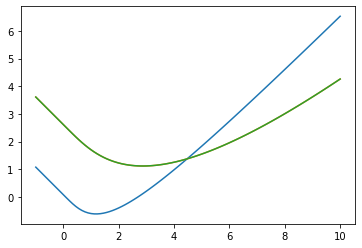

In [563]:
plt.plot(x, c)
plt.plot(x, c2)
plt.plot(x, c3)
# plt.axhline(0)

In [506]:
def lcgev_cdf(x, mu, sigma, xi):
    x = np.atleast_1d(x)
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = np.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g[x<support] = 0
    if xi < 0:
        g[x>support] = 1
    g[x<0] = 0
    return g

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


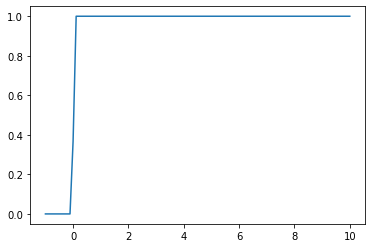

In [508]:
mine = lcgev_cdf(x, loc, 0.001, shape)
plt.plot(x, mine)

In [471]:
def crps_lcgev(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)
    p0 = gev_cdf(0, mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - gammainc(1-xi, -np.log(py))
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * gammainc(1-xi, -2 * np.log(p0))
    )
    return crps

In [477]:
x = np.linspace(0, 10, 100)

In [484]:
c = crps_lcgev(x, 5, scale, 1)
# c = gev_cdf(x, loc, scale, -0.5)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [485]:
np.min(c)

-0.371184114821942

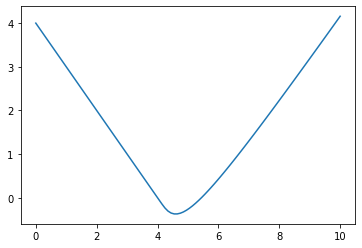

In [486]:
plt.plot(x, c)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


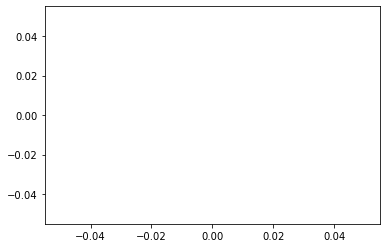

In [297]:
plt.plot(x, crps_gev(x, 0.7256, 1.024 , 1))

## Loss function

In [186]:
def lcgev_cdf_tf(x, mu, sigma, xi):
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = tf.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g = tf.where(x<support, 0, g)
#         g[x<support] = 0
    if xi < 0:
        g = tf.where(x>support, 1, g)
#         g[x>support] = 1
#     g[x<0] = 0
    g = tf.where(x<0, 0, g)
    return g

In [262]:
def crps_lcgev_tf(y, mu, sigma, xi):
    py = lcgev_cdf_tf(y, mu, sigma, xi)
    p0 = lcgev_cdf_tf(0, mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -tf.math.log(tf.cast(py, 'float64'))), 'float16')
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -2 * tf.math.log(tf.cast(p0, 'float64'))), 'float16')
    )
    return crps

In [263]:
mu = tf.Variable(np.array([0.1]))
sigma = tf.Variable(np.array([1.]))
xi = tf.Variable(np.array([-0.5]))
y = np.array([0.5])

In [264]:
crps_lcgev_tf(y, mu, sigma, xi)

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a double tensor but is a half tensor [Op:Sub]

In [240]:
tf.constant(np.array([5.]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([5.])>

In [239]:
tf.math.igamma(tf.constant(np.array([5.])), 1.)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.00365985])>

In [225]:
tf.cast()

> <string>(3)raise_from()

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py(6653)raise_from_not_ok_status()
   6651   message = e.message + (" name: " + name if name is not None else "")
   6652   # pylint: disable=protected-access
-> 6653   six.raise_from(core._status_to_exception(e.code, message), None)
   6654   # pylint: enable=protected-access
   6655 

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py(4220)igamma()
   4218         raise
   4219     except _core._NotOkStatusException as e:
-> 4220       _ops.raise_from_not_ok_status(e, name)
   4221   # Add nodes to the TensorFlow graph.
   4222   try:

ipdb> u
> <ipython-input-220-9adfed58c1db>(8)crps_lcgev_tf()
      6     crps += mu * p0**2
      7     crps -= 2*sigma / xi * (
----> 8         1 - py - tf.math.igamma(1-tf.cast(xi, tf.float32), -tf.math.log(py))
      9     )
     10 #     pdb.set_trace()

ipdb> 1-tf.cast(xi, tf.float32)

In [194]:
crps_lcgev(0.5, 0.1, 1, -0.5)

array([0.18217712])

In [204]:
def crps_lcgev_loss(y_true, y_pred):
    mu, sigma, xi = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    sigma = tf.nn.relu(sigma)
    return crps_lcgev_tf(y_true, mu, sigma, xi)

## Synthetic data

In [265]:
X = np.random.rand(1000).astype('float32')
y = np.maximum(X + np.random.rand(1000)/10, 0).astype('float32')

In [266]:
X.shape, y.shape

((1000,), (1000,))

In [267]:
model = tf.keras.models.Sequential([
    Dense(3, input_shape=(1,))
])

In [268]:
model.compile('adam', crps_lcgev_loss, run_eagerly=True)

In [271]:
model.fit(X, y, epochs=20)

Epoch 1/20
32/32 [==============================] - 1s 20ms/step - loss: 0.1237
Epoch 2/20
32/32 [==============================] - 1s 17ms/step - loss: 0.0845
Epoch 3/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 4/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 5/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 6/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 7/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 8/20
32/32 [==============================] - 1s 16ms/step - loss: nan
Epoch 9/20
32/32 [==============================] - 1s 16ms/step - loss: nan
Epoch 10/20
32/32 [==============================] - 1s 17ms/step - loss: nan
Epoch 11/20
32/32 [==============================] - 1s 16ms/step - loss: nan
Epoch 12/20
32/32 [==============================] - 1s 16ms/step - loss: nan
Epoch 13/20
32/32 [==============================] - 1s 16ms/step -

In [274]:
p = model.predict(X)

In [275]:
p.max()

1.171

In [276]:
p.min()

0.1531

In [277]:
p.shape

(1000, 3)

In [280]:
p[5]

array([0.7256, 1.024 , 0.975 ], dtype=float16)

In [279]:
crps_lcgev_loss(y, p)

<tf.Tensor: shape=(1000,), dtype=float16, numpy=
array([-0.188    ,  0.01294  , -0.06104  ,  0.004395 ,        nan,
       -0.169    ,  0.02222  ,        nan, -0.04834  ,  0.01172  ,
       -0.00293  ,  0.001465 , -0.0698   , -0.004883 ,  0.01294  ,
       -0.06104  ,  0.006836 , -0.09326  ,        nan,  0.0166   ,
       -0.1201   ,  0.01111  ,  0.004883 ,  0.01538  , -0.1475   ,
        0.02185  , -0.02734  ,  0.01465  , -0.0415   , -0.1348   ,
        0.02051  ,  0.02051  ,  0.       , -0.0371   , -0.1343   ,
        0.       , -0.02246  , -0.00464  ,  0.004883 ,  0.0094   ,
       -0.0918   ,        nan,        nan,        nan, -0.03174  ,
        0.02124  , -0.0332   ,  0.00806  , -0.01318  ,  0.01672  ,
              nan, -0.05957  , -0.10596  , -0.1406   ,  0.000977 ,
              nan,  0.001465 , -0.04102  , -0.03955  ,        nan,
              nan,  0.01465  ,  0.01062  ,  0.007446 , -0.1426   ,
              nan, -0.04932  , -0.1201   ,        nan,  0.01587  ,
        0.003